reading the  ipdr csv file

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report,confusion_matrix
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
#from preprocess import preprocess_ipdr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd


In [ ]:
df = pd.read_csv("/content/synthetic_gps_ipdr_cdr_labeled.csv", parse_dates=["timestamp"])
df = df.dropna(subset=["timestamp"])


In [ ]:
df.head()

,timestamp,lat,lon,domain,contact,call_type,anomaly
0,2024-07-01 08:00:00,21.308528,72.740936,google.com,+91-11111-22222,outgoing,1
1,2024-07-01 08:05:00,28.695071,77.154190,torvpn.io,+91-12345-67890,outgoing,1
2,2024-07-01 08:10:00,28.673199,77.187295,telegram.org,+91-12345-67890,incoming,1
3,2024-07-01 08:15:00,28.659866,77.173222,torvpn.io,+91-11111-22222,missed,1
4,2024-07-01 08:20:00,28.615602,77.180656,google.com,+91-98765-43210,incoming,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1000 non-null   datetime64[ns]
 1   lat        1000 non-null   float64       
 2   lon        1000 non-null   float64       
 3   domain     1000 non-null   object        
 4   contact    1000 non-null   object        
 5   call_type  1000 non-null   object        
 6   anomaly    1000 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 54.8+ KB


In [ ]:
df.drop("contact", axis=1, inplace=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])


In [ ]:
# -------------------------------
# STEP 2: Feature Engineering
# -------------------------------
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.sort_values('timestamp').reset_index(drop=True)

    df['speed_kmph'] = 0.0
    df['jump_distance_km'] = 0.0
    df['time_gap_secs'] = 0.0
    df['domain_category'] = df['domain'].str.contains('tor|telegram|vpn|onion', case=False, na=False).astype(int)
    df['hour'] = df['timestamp'].dt.hour
    df['night_activity'] = df['hour'].apply(lambda h: 1 if 0 <= h <= 5 else 0)
    df['device_change'] = 0
    df['geo_disparity_km'] = 0.0
    df['cross_source_overlap'] = 1
    df.loc[df.index % 300 == 0, 'device_change'] = 1
    for i in range(1, len(df)):
        prev = df.loc[i - 1]
        curr = df.loc[i]
        dist_km = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).km
        time_gap = (curr['timestamp'] - prev['timestamp']).total_seconds()
        df.at[i, 'jump_distance_km'] = dist_km
        df.at[i, 'time_gap_secs'] = time_gap
        if time_gap > 0:
            df.at[i, 'speed_kmph'] = dist_km / (time_gap / 3600)

    for i in range(0, len(df), 250):
        fake_ip_loc = (12.9716, 77.5946)
        gps_loc = (df.at[i, 'lat'], df.at[i, 'lon'])
        df.at[i, 'geo_disparity_km'] = geodesic(fake_ip_loc, gps_loc).km



    return df


engineer_features(df)

,timestamp,lat,lon,domain,call_type,anomaly,speed_kmph,jump_distance_km,time_gap_secs,domain_category,hour,night_activity,device_change,geo_disparity_km,cross_source_overlap
0,2024-07-01 08:00:00,21.308528,72.740936,google.com,outgoing,1,0.000000,0.000000,0.0,0,8,0,1,1057.08601,1
1,2024-07-01 08:05:00,28.695071,77.154190,torvpn.io,outgoing,1,11176.888905,931.407409,300.0,1,8,0,0,0.00000,1
2,2024-07-01 08:10:00,28.673199,77.187295,telegram.org,incoming,1,48.513514,4.042793,300.0,1,8,0,0,0.00000,1
3,2024-07-01 08:15:00,28.659866,77.173222,torvpn.io,missed,1,24.226650,2.018887,300.0,1,8,0,0,0.00000,1
4,2024-07-01 08:20:00,28.615602,77.180656,google.com,incoming,0,59.511846,4.959320,300.0,0,8,0,0,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2024-07-04 18:55:00,28.609158,77.165696,youtube.com,incoming,0,37.502079,3.125173,300.0,0,18,0,0,0.00000,1
996,2024-07-04 19:00:00,28.691731,77.195661,google.com,outgoing,0,115.308791,9.609066,300.0,0,19,0,0,0.00000,1
997,2024-07-04 19:05:00,28.613682,77.106896,telegram.org,incoming,1,147.034926,12.252910,300.0,1,19,0,0,0.00000,1
998,2024-07-04 19:10:00,28.695024,77.105705,torvpn.io,missed,1,108.190530,9.015878,300.0,1,19,0,0,0.00000,1


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

def preprocess_timeline_data(df, scale=True):
    """
    Preprocesses the forensic timeline data.
    - Parses timestamp
    - Fills missing values
    - Encodes user_id
    - Scales features if scale=True
    Returns: cleaned_df, raw_X, scaled_X (if scale), fitted scaler
    """
    df = df.copy()

    # Parse timestamps
    if not np.issubdtype(df["timestamp"].dtype, np.datetime64):
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df.dropna(subset=["timestamp"], inplace=True)

    # Numeric columns
    numeric_cols = ["lat", "lon", "upload", "download", "duration"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

    # Encode user_id if present
    if "domain" in df.columns:
        le_domain = LabelEncoder()
        le_call_type = LabelEncoder()

        df = le_domain.fit_transform(df["domain"])
        df = le_call_type.fit_transform(df["call_type"])
    # Add hour if missing
    if "hour" not in df.columns:
        df["hour"] = df["timestamp"].dt.hour

    # Build feature set
    exclude = ["timestamp", "is_anomaly", "user_id"]
    feature_cols = [col for col in df.columns if col not in exclude]
    X_raw = df[feature_cols]

    # Scale features
    scaler = None
    X_scaled = None
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)

    return df, X_raw, X_scaled, scaler
preprocess_timeline_data(df)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
y=df["is_anomaly"]
preprocess_timeline_data(df)
X=df[["lat", "lon", "upload", "download", "duration"]]

In [ ]:
# --- Isolation Forest ---
iso_model = IsolationForest(contamination=0.1, random_state=42)
iso_model.fit(X)
iso_preds = iso_model.predict(X)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

print("\n🔍 Isolation Forest Report")


print(classification_report(y, iso_preds))


🔍 Isolation Forest Report
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       116
           1       0.20      0.09      0.12        34

    accuracy                           0.71       150
   macro avg       0.49      0.49      0.48       150
weighted avg       0.64      0.71      0.67       150



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic

# Load and sort
df = pd.read_csv("gps_ipdr_cdr.csv", parse_dates=["timestamp"])
df.sort_values("timestamp", inplace=True)

# Feature engineering
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday

# Calculate movement distance
coords = df[['latitude', 'longitude']].values
df['distance_km'] = [geodesic(coords[i], coords[i - 1]).km if i > 0 else 0 for i in range(len(coords))]

# Frequency features
df['domain_freq'] = df.groupby('domain')['domain'].transform('count')
df['ip_freq'] = df.groupby('ip')['ip'].transform('count')
df['call_duration'] = df['duration'].fillna(0)

# Final features
features = df[['hour', 'weekday', 'distance_km', 'domain_freq', 'ip_freq', 'call_duration']]
scaler = StandardScaler()
X = scaler.fit_transform(features)


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

# -------------------------------
# STEP 1: Load Dataset
# -------------------------------
df = pd.read_csv("synthetic_gps_ipdr_cdr_labeled.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])


# -------------------------------
# STEP 2: Feature Engineering
# -------------------------------
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.sort_values('timestamp').reset_index(drop=True)

    df['speed_kmph'] = 0.0
    df['jump_distance_km'] = 0.0
    df['time_gap_secs'] = 0.0
    df['domain_category'] = df['domain'].str.contains('tor|telegram|vpn|onion', case=False, na=False).astype(int)
    df['hour'] = df['timestamp'].dt.hour
    df['night_activity'] = df['hour'].apply(lambda h: 1 if 0 <= h <= 5 else 0)
    df['device_change'] = 0
    df['geo_disparity_km'] = 0.0
    df['cross_source_overlap'] = 1

    df.loc[df.index % 300 == 0, 'device_change'] = 1
    for i in range(1, len(df)):
        prev = df.loc[i - 1]
        curr = df.loc[i]
        dist_km = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).km
        time_gap = (curr['timestamp'] - prev['timestamp']).total_seconds()
        df.at[i, 'jump_distance_km'] = dist_km
        df.at[i, 'time_gap_secs'] = time_gap
        if time_gap > 0:
            df.at[i, 'speed_kmph'] = dist_km / (time_gap / 3600)

    for i in range(0, len(df), 250):
        fake_ip_loc = (12.9716, 77.5946)
        gps_loc = (df.at[i, 'lat'], df.at[i, 'lon'])
        df.at[i, 'geo_disparity_km'] = geodesic(fake_ip_loc, gps_loc).km



    return df

df = engineer_features(df)


# -------------------------------
# STEP 3: Prepare Features
# -------------------------------
feature_cols = [
    'speed_kmph', 'jump_distance_km', 'time_gap_secs', 'domain_category',
    'device_change', 'cross_source_overlap', 'night_activity', 'geo_disparity_km'
]
X = df[feature_cols].values
y = df['anomaly'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train = X_scaled[y == 0]  # Only normal samples
X_test = X_scaled
y_test = y


# -------------------------------
# STEP 4: Autoencoder
# -------------------------------
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation="relu", activity_regularizer=regularizers.l1(1e-4))(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# -------------------------------
# STEP 5: Evaluate
# -------------------------------
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
threshold = np.percentile(mse[y == 0], 95)
y_pred = (mse > threshold).astype(int)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1797 - val_loss: 0.1725
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8112 - val_loss: 0.1500
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8918 - val_loss: 0.1343
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5466 - val_loss: 0.1256
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6166 - val_loss: 0.1201
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6996 - val_loss: 0.1153
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6714 - val_loss: 0.1115
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3286 - val_loss: 0.1078
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3076 - val_loss: 0.1050
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3469 - val_loss: 0.1024
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2994 - val_loss: 0.0997
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5147 - val_l

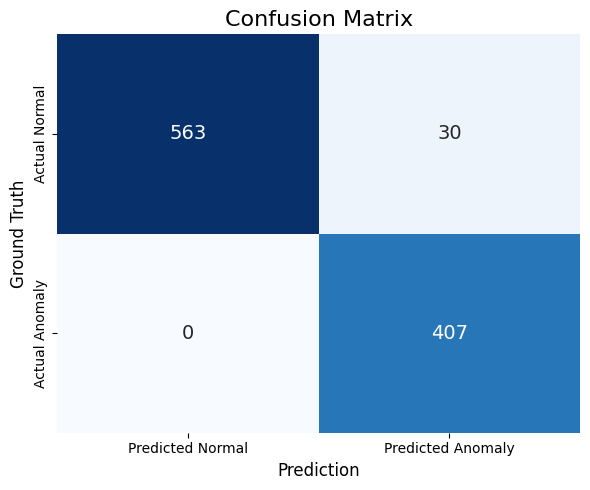

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Normal", "Anomaly"]

# Create a DataFrame for nicer plotting
conf_matrix_df = pd.DataFrame(cm, index=[f"Actual {l}" for l in labels],
                                 columns=[f"Predicted {l}" for l in labels])

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 14})
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Ground Truth", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_thresholds(mse, y_true, percentiles=range(90, 100, 1)):
    results = []

    print("Autoencoder Threshold Evaluation:\n")
    for p in percentiles:
        threshold = np.percentile(mse[y_true == 0], p)
        y_pred = (mse > threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

        tn, fp, fn, tp = cm.ravel()

        results.append({
            "Percentile": p,
            "Threshold": round(threshold, 4),
            "Precision": round(report['1']['precision'], 3),
            "Recall": round(report['1']['recall'], 3),
            "F1-Score": round(report['1']['f1-score'], 3),
            "False Positives": fp,
            "False Negatives": fn
        })

        print(f"--- Percentile: {p}% ---")
        print(f"Threshold: {threshold:.4f}")
        print(f"Precision: {report['1']['precision']:.3f} | Recall: {report['1']['recall']:.3f} | F1: {report['1']['f1-score']:.3f}")
        print(f"False Positives: {fp} | False Negatives: {fn}")
        print(f"Confusion Matrix:\n{cm}\n")

    return pd.DataFrame(results)

# Run evaluation
threshold_results = evaluate_thresholds(mse, y_test)


Autoencoder Threshold Evaluation:

--- Percentile: 90% ---
Threshold: 0.0163
Precision: 0.872 | Recall: 1.000 | F1: 0.931
False Positives: 60 | False Negatives: 0
Confusion Matrix:
[[533  60]
 [  0 407]]

--- Percentile: 91% ---
Threshold: 0.0163
Precision: 0.883 | Recall: 1.000 | F1: 0.938
False Positives: 54 | False Negatives: 0
Confusion Matrix:
[[539  54]
 [  0 407]]

--- Percentile: 92% ---
Threshold: 0.0164
Precision: 0.895 | Recall: 1.000 | F1: 0.944
False Positives: 48 | False Negatives: 0
Confusion Matrix:
[[545  48]
 [  0 407]]

--- Percentile: 93% ---
Threshold: 0.0164
Precision: 0.906 | Recall: 1.000 | F1: 0.951
False Positives: 42 | False Negatives: 0
Confusion Matrix:
[[551  42]
 [  0 407]]

--- Percentile: 94% ---
Threshold: 0.0165
Precision: 0.919 | Recall: 1.000 | F1: 0.958
False Positives: 36 | False Negatives: 0
Confusion Matrix:
[[557  36]
 [  0 407]]

--- Percentile: 95% ---
Threshold: 0.0166
Precision: 0.931 | Recall: 1.000 | F1: 0.964
False Positives: 30 | False 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

def evaluate_thresholds(mse, y_true, percentiles=range(90, 100, 1)):
    results = []

    print("Autoencoder Threshold Evaluation:\n")
    for p in percentiles:
        threshold = np.percentile(mse[y_true == 0], p)
        y_pred = (mse > threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

        # Unpack confusion matrix
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0  # Edge case safety fallback

        results.append({
            "Percentile": p,
            "Threshold": round(threshold, 6),
            "Precision": round(report['1']['precision'], 4),
            "Recall": round(report['1']['recall'], 4),
            "F1-Score": round(report['1']['f1-score'], 4),
            "False Positives": fp,
            "False Negatives": fn,
            "TP": tp,
            "TN": tn
        })

        print(f"--- Percentile: {p}% ---")
        print(f"Threshold: {threshold:.6f}")
        print(f"Precision: {report['1']['precision']:.4f} | Recall: {report['1']['recall']:.4f} | F1: {report['1']['f1-score']:.4f}")
        print(f"False Positives: {fp} | False Negatives: {fn}")
        print(f"Confusion Matrix:\n{cm}\n")

    df_results = pd.DataFrame(results)
    return df_results

# Run evaluation
threshold_results = evaluate_thresholds(mse, y_test)

# Display the resulting DataFrame
print("\nSummary Table:\n")
print(threshold_results)


Autoencoder Threshold Evaluation:

--- Percentile: 90% ---
Threshold: 0.016254
Precision: 0.8715 | Recall: 1.0000 | F1: 0.9314
False Positives: 60 | False Negatives: 0
Confusion Matrix:
[[533  60]
 [  0 407]]

--- Percentile: 91% ---
Threshold: 0.016327
Precision: 0.8829 | Recall: 1.0000 | F1: 0.9378
False Positives: 54 | False Negatives: 0
Confusion Matrix:
[[539  54]
 [  0 407]]

--- Percentile: 92% ---
Threshold: 0.016357
Precision: 0.8945 | Recall: 1.0000 | F1: 0.9443
False Positives: 48 | False Negatives: 0
Confusion Matrix:
[[545  48]
 [  0 407]]

--- Percentile: 93% ---
Threshold: 0.016414
Precision: 0.9065 | Recall: 1.0000 | F1: 0.9509
False Positives: 42 | False Negatives: 0
Confusion Matrix:
[[551  42]
 [  0 407]]

--- Percentile: 94% ---
Threshold: 0.016475
Precision: 0.9187 | Recall: 1.0000 | F1: 0.9576
False Positives: 36 | False Negatives: 0
Confusion Matrix:
[[557  36]
 [  0 407]]

--- Percentile: 95% ---
Threshold: 0.016567
Precision: 0.9314 | Recall: 1.0000 | F1: 0.964

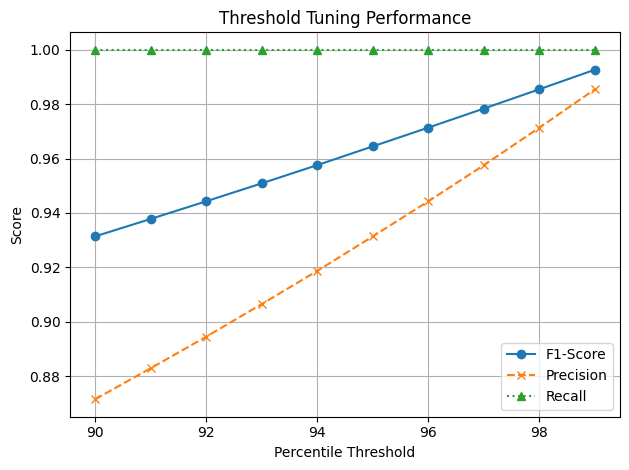

In [ ]:
import matplotlib.pyplot as plt

plt.plot(threshold_results["Percentile"], threshold_results["F1-Score"], marker='o', label='F1-Score')
plt.plot(threshold_results["Percentile"], threshold_results["Precision"], marker='x', linestyle='--', label='Precision')
plt.plot(threshold_results["Percentile"], threshold_results["Recall"], marker='^', linestyle=':', label='Recall')
plt.title("Threshold Tuning Performance")
plt.xlabel("Percentile Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Find best threshold with high precision and still good F1
filtered = threshold_results[
    (threshold_results["Precision"] >= 0.97) &
    (threshold_results["Recall"] >= 0.99)
]

best = filtered.sort_values("F1-Score", ascending=False).head(1)
print("💡 Recommended Threshold Settings:")
print(best)


💡 Recommended Threshold Settings:
   Percentile  Threshold  Precision  Recall  F1-Score  False Positives  \
9          99   0.016897     0.9855     1.0    0.9927                6   

   False Negatives   TP   TN  
9                0  407  587  


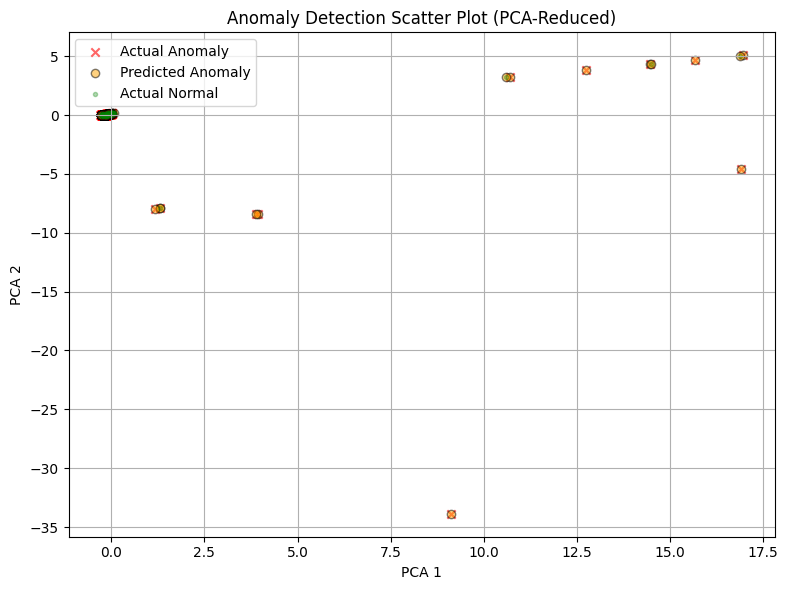

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Step 1: Reduce to 2D
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_scaled)

# Step 2: Prepare labels
actual = y_test              # Ground truth
predicted = y_pred           # From autoencoder

# Step 3: Scatter Plot
plt.figure(figsize=(8, 6))

# Actual anomalies (ground truth)
plt.scatter(X_2D[actual == 1, 0], X_2D[actual == 1, 1],
            c='red', marker='x', label='Actual Anomaly', alpha=0.6)

# Predicted anomalies by model
plt.scatter(X_2D[predicted == 1, 0], X_2D[predicted == 1, 1],
            c='orange', marker='o', edgecolor='black', label='Predicted Anomaly', alpha=0.5)

# Actual normal points
plt.scatter(X_2D[actual == 0, 0], X_2D[actual == 0, 1],
            c='green', marker='.', label='Actual Normal', alpha=0.3)

plt.title("Anomaly Detection Scatter Plot (PCA-Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import sqlite3, os
from datetime import datetime, timedelta
import random

output_dir = "android_logical_image_sample/data"
os.makedirs(output_dir, exist_ok=True)

# --- 1. SMS DB ---
sms_conn = sqlite3.connect(os.path.join(output_dir, "mmssms.db"))
sms_conn.execute("CREATE TABLE sms (address TEXT, date INTEGER, body TEXT)")
now = int(datetime.now().timestamp() * 1000)
sms_samples = [
    ("VK-SBI", now - 500000, "Your OTP is 987654. Do not share."),
    ("AD-PAYTM", now - 400000, "Paytm KYC alert. Verify now."),
    ("RM-ZOMATO", now - 300000, "Order placed successfully."),
]
sms_conn.executemany("INSERT INTO sms (address, date, body) VALUES (?, ?, ?)", sms_samples)
sms_conn.commit()

# --- 2. Call Log DB ---
call_conn = sqlite3.connect(os.path.join(output_dir, "calllog.db"))
call_conn.execute("CREATE TABLE calls (number TEXT, date INTEGER, duration INTEGER, type INTEGER)")
call_samples = [
    ("9876543210", now - 200000, 30, 2),  # Incoming
    ("1234567890", now - 100000, 0, 3),   # Missed
]
call_conn.executemany("INSERT INTO calls VALUES (?, ?, ?, ?)", call_samples)
call_conn.commit()

# --- 3. App Usage DB ---
event_conn = sqlite3.connect(os.path.join(output_dir, "event_logs.db"))
event_conn.execute("CREATE TABLE usage_events (time INTEGER, package_name TEXT, event_type INTEGER)")
events = [
    (now - 490000, "com.whatsapp", 1),
    (now - 390000, "com.google.android.gm", 1),
    (now - 290000, "com.phonepe.app", 1),
]
event_conn.executemany("INSERT INTO usage_events VALUES (?, ?, ?)", events)
event_conn.commit()

print("✅ Mock logical image generated.")


✅ Mock logical image generated.
